In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras = tf.keras

In [2]:
def plot_series(time,series,format='-',start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end],format,label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [3]:
def trend(time,slope=0):
  return slope * time

In [4]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time *2 * np.pi),
                  1 / np.exp( 3 * season_time))

In [5]:
def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time +phase)% period) /period
  return amplitude * seasonal_pattern(season_time)

In [10]:
def white_noise(time,noise_level=1,seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.rand(len(time)) * noise_level

In [11]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:
def model_forecast(model,series,window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

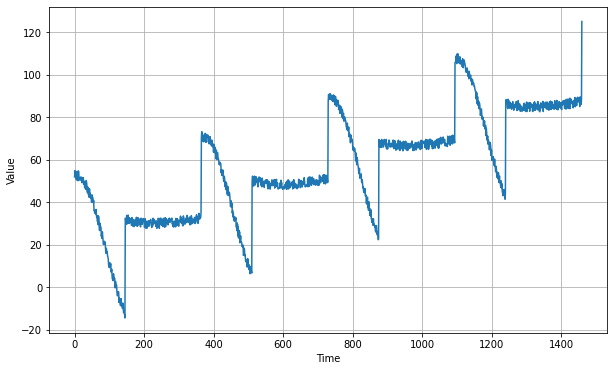

In [13]:
time = np.arange(4 * 365 +1)

slope = 0.05
base_line = 10
amplitude = 40
series = base_line + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed = 42)

series += noise

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [15]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Linear model

In [18]:
%%time

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1,input_shape=[window_size])
])

optimizer = keras.optimizers.SGD(lr=1e-5,momentum = 0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics=['mae']
)

model.fit(train_set,epochs = 100, validation_data = valid_set)

Epoch 1/100
31/31 [==============================] - 3s 11ms/step - loss: 70.5901 - mae: 71.0890 - val_loss: 24.0818 - val_mae: 24.5816
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 10.0368 - mae: 10.5228 - val_loss: 6.8462 - val_mae: 7.3272
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 5.9524 - mae: 6.4204 - val_loss: 5.4443 - val_mae: 5.9070
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 5.1668 - mae: 5.6384 - val_loss: 6.0407 - val_mae: 6.5171
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 5.1674 - mae: 5.6299 - val_loss: 5.3318 - val_mae: 5.8032
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 5.3586 - mae: 5.8258 - val_loss: 5.3845 - val_mae: 5.8556
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 5.5475 - mae: 6.0105 - val_loss: 5.6649 - val_mae: 6.1318
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 5.2

In [21]:
%%time

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train,window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1,input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30)
)

optimizer = keras.optimizers.SGD(lr=1e-6,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set,epochs = 100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 72.6645 - mae: 73.1639
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 58.5314 - mae: 59.0307
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.4508 - mae: 38.9506
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 19.0991 - mae: 19.5977
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 5.1545 - mae: 5.6213
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 4.8232 - mae: 5.2889
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 4.8681 - mae: 5.3382
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 4.3158 - mae: 4.7846
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 4.2524 - mae: 4.7215
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 4.3752 - mae: 4.8399
Epoch 11/100
31/31 [==============================]

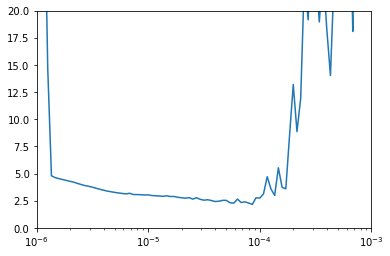

In [23]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-6,1e-3,0,20])
plt.show()

In [25]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1,input_shape=[window_size])
])

optimizer = keras.optimizers.SGD(lr=1e-5,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set,
          epochs=500,
          validation_data= valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 8ms/step - loss: 70.5901 - mae: 71.0890 - val_loss: 24.0818 - val_mae: 24.5816
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 10.0368 - mae: 10.5228 - val_loss: 6.8462 - val_mae: 7.3272
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 5.9524 - mae: 6.4204 - val_loss: 5.4443 - val_mae: 5.9070
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 5.1668 - mae: 5.6384 - val_loss: 6.0407 - val_mae: 6.5171
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 5.1674 - mae: 5.6299 - val_loss: 5.3318 - val_mae: 5.8032
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 5.3586 - mae: 5.8258 - val_loss: 5.3845 - val_mae: 5.8556
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5475 - mae: 6.0105 - val_loss: 5.6649 - val_mae: 6.1318
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 5.21

In [29]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [30]:
lin_forecast.shape

(461,)

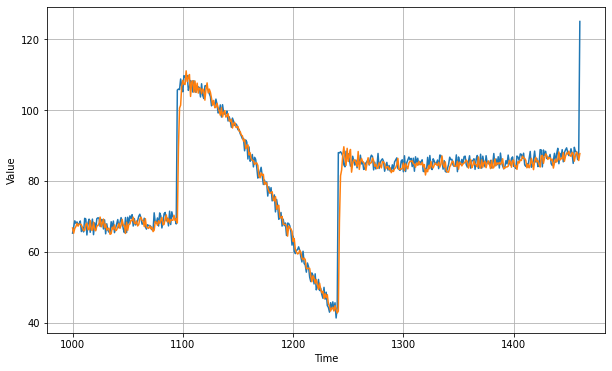

In [31]:
plt.figure(figsize=(10,6))

plot_series(time_valid,x_valid)
plot_series(time_valid,lin_forecast)

In [32]:
keras.metrics.mean_absolute_error(x_valid,lin_forecast).numpy()

1.9924971

# Dense Model Forecasting

In [34]:
%%time

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

train_set = window_dataset(x_train,window_size)

model = keras.models.Sequential([
        keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
        keras.layers.Dense(10,activation='relu'),
        keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-7 * 10 ** (epoch /20) )

optimizer = keras.optimizers.SGD(lr=1e-7,momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])


history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 46.1508 - mae: 46.6505
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 44.2564 - mae: 44.7562
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 40.3440 - mae: 40.8413
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 37.1049 - mae: 37.6046
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 32.2817 - mae: 32.7807
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27.9900 - mae: 28.4897
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 22.7271 - mae: 23.2258
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 16.9019 - mae: 17.3998
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 10.8417 - mae: 11.3355
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6000 - mae: 6.0788
Epoch 11/100
31/31 [=====================

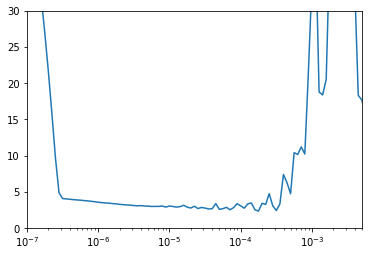

In [35]:
plt.semilogx(history.history['lr'],history.history['loss'])

plt.axis([1e-7,5e-3,0,30])
plt.show()

In [37]:
%%time

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = keras.models.Sequential([
        keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
        keras.layers.Dense(10,activation='relu'),
        keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set,
          epochs=500,
          validation_data = valid_set,
          callbacks=[early_stopping])



Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 29.4131 - mae: 29.9098 - val_loss: 6.0886 - val_mae: 6.5654
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 7.2684 - mae: 7.7514 - val_loss: 5.4887 - val_mae: 5.9646
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 6.0384 - mae: 6.5120 - val_loss: 4.7275 - val_mae: 5.1936
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 4.9093 - mae: 5.3713 - val_loss: 5.2390 - val_mae: 5.7198
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 4.8840 - mae: 5.3538 - val_loss: 3.8971 - val_mae: 4.3492
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 4.4225 - mae: 4.8904 - val_loss: 3.6771 - val_mae: 4.1408
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 4.3657 - mae: 4.8295 - val_loss: 3.4330 - val_mae: 3.8868
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 3.6808 

In [40]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:,0]

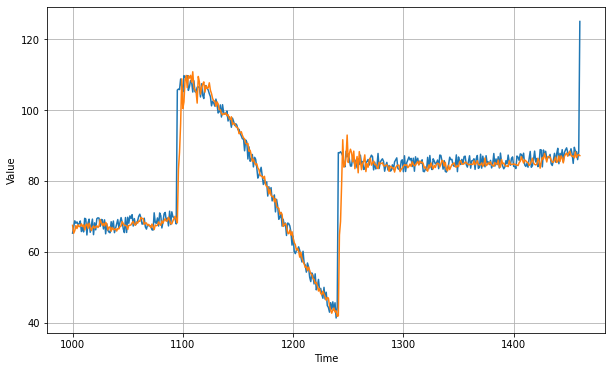

In [41]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,dense_forecast)

plt.show()

In [42]:
keras.metrics.mean_absolute_error(x_valid,dense_forecast).numpy()

2.0345175